In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import itertools
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

In [3]:
train = pd.read_csv('data/WSJ_02-21.pos', sep='\t', header=0, names=['word', 'pos'])
test = pd.read_csv('data/WSJ_24.pos', sep='\t', header=0, names=['word', 'pos'])
train.head()

,word,pos
0,an,DT
1,Oct.,NNP
2,19,CD
3,review,NN
4,of,IN


In [4]:
# find most common pos to apply to unk words in feature creation
Counter(train['pos']).most_common(1)

[('NN', 132935)]

In [5]:
# Strip some non pos tags from the input data
with open('data/penn_trebank.txt', 'tr') as f:
    content = f.readlines()

tidy = {}
for i in range(0, len(content)-1, 2):
    tidy[content[i].strip()] = content[i+1].strip()
    
tags_for_removal = set(train.pos.values)- set(tidy.keys())
print(f'tags in training, but not in the original treebank set: {tags_for_removal}')

tags in training, but not in the original treebank set: {'$', '.', '(', ',', '``', "''", '#', ')', ':'}


In [6]:
train = train[train['pos'].map(lambda x: x not in tags_for_removal)]

In [7]:
#Counter(train.itertuples(index=False, name=None)).most_common()

In [8]:
sequence_length = 5 # centre word, 2 before and 2 afer

In [9]:
input_data = []
for tup in train.itertuples(index=False, name=None):
    input_data.append(tup)
input_data[:20]

[('an', 'DT'),
 ('Oct.', 'NNP'),
 ('19', 'CD'),
 ('review', 'NN'),
 ('of', 'IN'),
 ('The', 'DT'),
 ('Misanthrope', 'NN'),
 ('at', 'IN'),
 ('Chicago', 'NNP'),
 ("'s", 'POS'),
 ('Goodman', 'NNP'),
 ('Theatre', 'NNP'),
 ('Revitalized', 'VBN'),
 ('Classics', 'NNS'),
 ('Take', 'VBP'),
 ('the', 'DT'),
 ('Stage', 'NN'),
 ('in', 'IN'),
 ('Windy', 'NNP'),
 ('City', 'NNP')]

In [10]:
def create_windowed_dataset(input_dat, sequence_length=5, mode='train'):
    matrix = []
    for index in range(len(input_dat)):
        if index+sequence_length>len(input_dat):
            break
        if mode=='train':
            matrix.append(input_dat[index:index+sequence_length])
        else:
            matrix.append([(a, None) for a in input_dat[index:index+sequence_length]])
        index+=sequence_length
    return matrix

In [11]:
train_matrix = create_windowed_dataset(input_data, mode='train')
train_matrix[:5]

[[('an', 'DT'), ('Oct.', 'NNP'), ('19', 'CD'), ('review', 'NN'), ('of', 'IN')],
 [('Oct.', 'NNP'),
  ('19', 'CD'),
  ('review', 'NN'),
  ('of', 'IN'),
  ('The', 'DT')],
 [('19', 'CD'),
  ('review', 'NN'),
  ('of', 'IN'),
  ('The', 'DT'),
  ('Misanthrope', 'NN')],
 [('review', 'NN'),
  ('of', 'IN'),
  ('The', 'DT'),
  ('Misanthrope', 'NN'),
  ('at', 'IN')],
 [('of', 'IN'),
  ('The', 'DT'),
  ('Misanthrope', 'NN'),
  ('at', 'IN'),
  ('Chicago', 'NNP')]]

In [12]:
suffixes = []
for item in set(train['word']):
    suffixes.append(item[-3:])
    
initial_letters = []
for item in set(train['word']):
    initial_letters.append(item[0])
    
pos_vocab = set(train['pos'])
index_to_pos = {k:v for k, v in enumerate(pos_vocab)}
pos_to_index = {v:k for k, v in index_to_pos.items()}

UNK = 0

word_vocab = set([UNK])
word_vocab.update(train['word'])
print(len(word_vocab))

word_vocab.update(suffixes)
print(len(word_vocab))

word_vocab.update(initial_letters)
print(len(word_vocab))

index_to_word = {k+len(pos_vocab): v for k, v in enumerate(word_vocab)}
word_to_index = defaultdict(None, {v:k for k, v in index_to_word.items()})

print(len(word_vocab), len(pos_vocab))

44364
47525
47546
47546 36


In [14]:
len(sorted(list(pos_vocab)))

36

In [25]:
winners = defaultdict()

for row in Counter(list(train.itertuples(index=False, name=None))):
    if row[0] not in winners:
        winners[row[0]] = row[1]
    elif winners[row[0]]< row[1]:
        winners[row[0]] = row[1]
        
print(f'There are {len(winners)} tuples in the dict')

for key in list(winners.keys())[:5]:
    print(key, winners[key])

There are 44363 tuples in the dict
an DT
Oct. NNP
19 CD
review VBP
of RP


In [26]:
import json
with open('jq/word_to_index.json', 'wt') as f:
    f.write(json.dumps(word_to_index))
    
with open('jq/pos_to_index.json', 'wt') as f:
    f.write(json.dumps(pos_to_index))
    
with open('jq/index_to_pos.json', 'wt') as f:
    f.write(json.dumps(index_to_pos))    
    
with open('jq/most_common_tag_for_word.json', 'wt') as f:
    f.write(json.dumps(winners))

In [28]:
def build_features(matrix, mode='train'):
    transformed_matrix = []

    for row in matrix:
        features = []

        if mode=='train':
            features.append(pos_to_index[row[1][1]])
            features.append(pos_to_index[row[0][1]])
        else:
            features.append(pos_to_index[winners.get(row[1][0], 'NN')])
            features.append(pos_to_index[winners.get(row[0][0], 'NN')])
            
        features.append(word_to_index.get(row[2][0][-3:], UNK))
        features.append(word_to_index.get(row[2][0][0], UNK))

        features.append(word_to_index.get(row[2][0], UNK))

        features.append(word_to_index.get(row[1][0], UNK))

        features.append(word_to_index.get(row[1][0][-3:], UNK))

        features.append(word_to_index.get(row[0][0], UNK))
        features.append(word_to_index.get(row[3][0], UNK))    
        features.append(word_to_index.get(row[3][0][-3:], UNK))
        features.append(word_to_index.get(row[4][0], UNK))
        
        if mode=='train':
            features.append(pos_to_index[row[2][1]])
        
        transformed_matrix.append(features)
    return transformed_matrix

In [29]:
transformed_matrix = build_features(train_matrix, mode='train')
transformed_matrix[:5]

[[22, 28, 21743, 12906, 21743, 13275, 10011, 4760, 47374, 28343, 20172, 7],
 [7, 22, 28343, 9597, 47374, 21743, 21743, 13275, 20172, 20172, 27230, 19],
 [19, 7, 20172, 32990, 20172, 47374, 28343, 21743, 27230, 27230, 10359, 32],
 [32, 19, 27230, 24316, 27230, 20172, 20172, 47374, 10359, 12262, 14705, 28],
 [28, 32, 12262, 32693, 10359, 27230, 27230, 20172, 14705, 14705, 14115, 19]]

In [30]:
def get_model(vocab_size, d_model):

    model = keras.Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=d_model, input_length=11))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dropout(.1))
    model.add(layers.Dense(len(pos_vocab), activation='sigmoid'))

    return model

In [31]:
model = get_model(len(word_vocab)+len(pos_vocab), 100)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 11, 100)           4758200   
_________________________________________________________________
flatten (Flatten)            (None, 1100)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               110100    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 36)                3636      
Total params: 4,871,936
Trainable params: 4,871,936
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.CategoricalCrossentropy()
              , metrics=[keras.metrics.CategoricalAccuracy()])

In [33]:
X, y = np.array(transformed_matrix)[:, :-1], keras.utils.to_categorical(np.array(transformed_matrix)[:, -1], num_classes=len(pos_vocab))
X.shape, y.shape

((832779, 11), (832779, 36))

In [34]:
max_train_size = 50000
X_train = X[:max_train_size]
X_test = X[max_train_size:max_train_size+int(.1*max_train_size)]

y_train = y[:max_train_size]
y_test = y[max_train_size:max_train_size+int(.1*max_train_size)]

In [37]:
CHECKPOINT_DIR = 'data/model/checkpoints'

Epoch 1/10
1563/1563 [==============================] - 67s 43ms/step - loss: 0.0075 - categorical_accuracy: 0.9978 - val_loss: 0.2807 - val_categorical_accuracy: 0.9392
INFO:tensorflow:Assets written to: data/model/checkpoints/assets
Epoch 2/10
1563/1563 [==============================] - 62s 40ms/step - loss: 0.0046 - categorical_accuracy: 0.9987 - val_loss: 0.3098 - val_categorical_accuracy: 0.9388
Epoch 3/10
1563/1563 [==============================] - 62s 39ms/step - loss: 0.0035 - categorical_accuracy: 0.9990 - val_loss: 0.3309 - val_categorical_accuracy: 0.9352


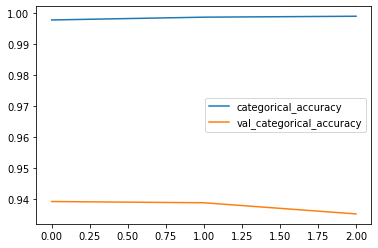

In [39]:
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_test, y_test), 
                    batch_size=32, 
                    epochs=10, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=2),
                              tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_DIR, monitor='val_categorical_accuracy',
                                                                save_best_only=True)])

for key in ['categorical_accuracy', 'val_categorical_accuracy']:
    plt.plot(history.history[key], label=key)
plt.legend()
plt.show()

In [36]:
#model.save('data/model')

INFO:tensorflow:Assets written to: data/model/assets


In [40]:
results = []
for a in range(1000):
    results.append(np.argmax(model.predict(X_test[a].reshape(1,-1)))==np.argmax(y_test[a]))
    if not a%100:
        print(np.mean(results))

1.0
0.8910891089108911
0.9104477611940298
0.9136212624584718
0.9152119700748129
0.9221556886227545
0.930116472545757
0.9358059914407989
0.9375780274656679
0.9334073251942286


In [41]:
model = tf.keras.models.load_model('data/model/checkpoints')

In [42]:
np.argmax(model.predict(np.array([1,2,3,4,5,6,7,8,9,0,11]).reshape(1,-1)))

5

In [58]:
it = train.itertuples(index=False, name=None)
row = []
for a in range (5):
    row.append(next(it))

In [59]:
row

[('an', 'DT'), ('Oct.', 'NNP'), ('19', 'CD'), ('review', 'NN'), ('of', 'IN')]

In [62]:
word_to_index.get(row[2][0][-3:])

21743

In [65]:
features = build_features([row], mode='predict')
features

[[22, 28, 21743, 12906, 21743, 13275, 10011, 4760, 47374, 28343, 20172]]

In [66]:
prediction = model.predict(np.array(features).reshape(1,-1))
prediction

array([[1.12113616e-04, 1.91256404e-03, 2.20805407e-04, 7.51197338e-04,
        9.04930651e-01, 4.24202790e-06, 4.64832519e-05, 9.99998510e-01,
        4.26965952e-03, 4.86189783e-05, 9.74017382e-03, 2.08109617e-04,
        2.33739614e-04, 7.53270209e-01, 2.70333886e-02, 5.02672791e-03,
        8.19615722e-02, 2.05039561e-01, 1.25606375e-05, 5.99734187e-02,
        1.53848231e-02, 6.12073243e-02, 5.02325654e-01, 6.78394426e-05,
        8.23019862e-01, 9.53614712e-04, 1.45196915e-03, 4.45395708e-04,
        1.65224314e-01, 8.26805830e-04, 5.08755445e-03, 4.28003073e-03,
        6.75513446e-02, 1.18012758e-04, 5.32925478e-05, 6.58847193e-06]],
      dtype=float32)

# Make predictions on large body of text

In [67]:
from nltk import word_tokenize

with open('data/bleak.txt', 'rt') as f:
    content = f.read()
print(content[:100])

﻿CHAPTER I

In Chancery


London. Michaelmas term lately over, and the Lord Chancellor sitting
in Li


In [68]:
# strip some punctuation
tokens = word_tokenize(content)
tokens = [token for token in tokens if token not in list(',.;()\'!?')+['--']+['\'\'']+['``']]

In [69]:
tokens[:20]

['\ufeffCHAPTER',
 'I',
 'In',
 'Chancery',
 'London',
 'Michaelmas',
 'term',
 'lately',
 'over',
 'and',
 'the',
 'Lord',
 'Chancellor',
 'sitting',
 'in',
 'Lincoln',
 "'s",
 'Inn',
 'Hall',
 'Implacable']

In [70]:
predict_matrix = create_windowed_dataset(tokens, mode='predict')
predict_matrix[:5]

[[('\ufeffCHAPTER', None),
  ('I', None),
  ('In', None),
  ('Chancery', None),
  ('London', None)],
 [('I', None),
  ('In', None),
  ('Chancery', None),
  ('London', None),
  ('Michaelmas', None)],
 [('In', None),
  ('Chancery', None),
  ('London', None),
  ('Michaelmas', None),
  ('term', None)],
 [('Chancery', None),
  ('London', None),
  ('Michaelmas', None),
  ('term', None),
  ('lately', None)],
 [('London', None),
  ('Michaelmas', None),
  ('term', None),
  ('lately', None),
  ('over', None)]]

In [71]:
transformed_matrix = build_features(predict_matrix, mode='predict')

In [72]:
transformed_matrix[:5]

[[12, 19, 37443, 32664, 37443, 32664, 32664, 0, 29356, 41318, 39455],
 [2, 12, 41318, 29788, 29356, 37443, 37443, 32664, 39455, 34215, 0],
 [22, 2, 34215, 8179, 39455, 29356, 41318, 37443, 0, 6879, 18152],
 [22, 22, 6879, 32693, 0, 39455, 34215, 29356, 18152, 11338, 19580],
 [19, 22, 11338, 26469, 18152, 0, 6879, 39455, 19580, 18722, 33921]]

In [107]:
parts_of_speech = [index_to_pos[a] for a in np.argmax(model.predict(np.array(transformed_matrix)), axis=1)]

In [119]:
results = []
for a in zip(tokens[2:-2], parts_of_speech):
    results.append(a)
results[:10]

[('In', 'IN'),
 ('Chancery', 'NNP'),
 ('London', 'NNP'),
 ('Michaelmas', 'NNP'),
 ('term', 'NN'),
 ('lately', 'RB'),
 ('over', 'IN'),
 ('and', 'CC'),
 ('the', 'DT'),
 ('Lord', 'NNP')]

In [120]:
len(results)

358608

In [118]:
pd.DataFrame(results, columns = ['word', 'pos']).to_csv('data/pos_tagged_bleak_house_FULL.csv')

In [74]:
tokens[:20]

['\ufeffCHAPTER',
 'I',
 'In',
 'Chancery',
 'London',
 'Michaelmas',
 'term',
 'lately',
 'over',
 'and',
 'the',
 'Lord',
 'Chancellor',
 'sitting',
 'in',
 'Lincoln',
 "'s",
 'Inn',
 'Hall',
 'Implacable']

In [75]:
len(tokens), len(transformed_matrix)

(358612, 358608)

In [123]:
bleak = pd.read_csv('data/pos_tagged_bleak_house_FULL.csv')
bleak[bleak['word']=='Thank']

,Unnamed: 0,word,pos
9623,9623,Thank,LS
31465,31465,Thank,NNP
50759,50759,Thank,NNP
55522,55522,Thank,LS
55545,55545,Thank,CC
70938,70938,Thank,LS
75044,75044,Thank,NNP
79375,79375,Thank,NNP
84754,84754,Thank,VBP
112777,112777,Thank,NNP
